In [2]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

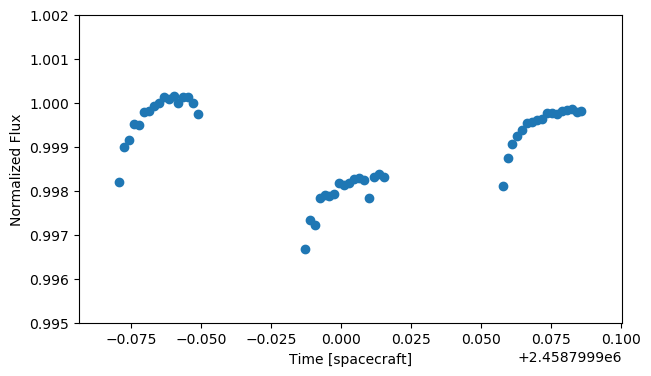

In [3]:
## Loading in the extracted HST data, from my 'HST Image Reduction' notebook
orbit2data = np.load('/home/mmmurphy/data/hd219666b/reduced_data/orbit2_extractednormalizedbroadbanddata.npz')
times_o2 = orbit2data['times']
flux_o2 = orbit2data['broadbandflux']
errs_o2 = orbit2data['broadbanderrs']
orbit3data = np.load('/home/mmmurphy/data/hd219666b/reduced_data/orbit3_extractednormalizedbroadbanddata.npz')
times_o3 = orbit3data['times']
flux_o3 = orbit3data['broadbandflux']
errs_o3 = orbit3data['broadbanderrs']
orbit4data = np.load('/home/mmmurphy/data/hd219666b/reduced_data/orbit4_extractednormalizedbroadbanddata.npz')
times_o4 = orbit4data['times']
flux_o4 = orbit4data['broadbandflux']
errs_o4 = orbit4data['broadbanderrs']

times_h = np.concatenate([times_o2, times_o3, times_o4])
fluxes_h = np.concatenate([flux_o2, flux_o3, flux_o4])
errors_h = np.concatenate([errs_o2, errs_o3, errs_o4])
orbit_ends = np.array([len(times_o2), len(times_o2)+len(times_o3), len(times_o2)+len(times_o3)+len(times_o4)])
# note for the orbit_ends array
# it's defined so that e.g. times[:orbit_ends[0]] returns only values in the second orbit (we don't use first orbit)
#                           times[orbit_ends[0]:orbit_ends[1]] in the third orbit

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(times_h, fluxes_h)
ax.set(xlabel='Time [spacecraft]', ylabel='Normalized Flux', ylim=(0.995, 1.002))
plt.show()

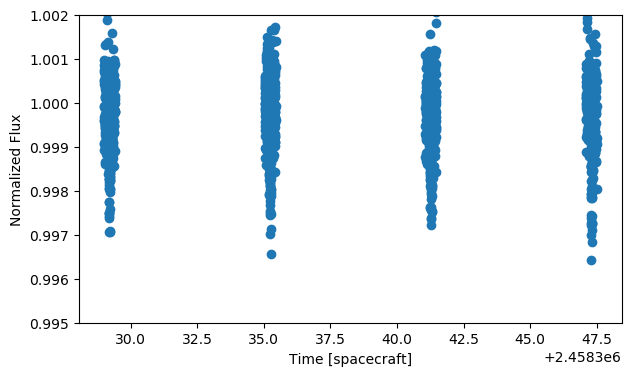

In [4]:
## Loading in the prepped TESS data, from my 'Preparing TESS Data' notebook
tessdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/shortened_TESS_lightcurve.npz')
times_t_readin = tessdata['times']
tvoid = np.copy(times_t_readin).astype(float)
times_t = np.array(tvoid)
fluxes_t = tessdata['fluxes']
errors_t = tessdata['errs']

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(times_t, fluxes_t)
ax.set(xlabel='Time [spacecraft]', ylabel='Normalized Flux', ylim=(0.995, 1.002))
plt.show()

In [31]:
##
# Defining my parameter arrays (inits, priors, etc)
#
# General Structure:
# 0 = tc
# 1 = log10P
# 2 = log10(a/Rstar)
# 3 = cos(i)
# 4 = Rp / Rstar in HST bandpass
# 5,6,7 = hook model amplitudes
# 8,9,10 = hook model time-scales
# 11 = Rp/Rstar in TESS bandpass

labels = np.asarray(['tc', 'log10P', 'log10a', 'cosi', 'RpRs_hst', 'amp1', 'amp2', 'amp3', 'tau1', 'tau2', 'tau3', 'RpRs_tess', 'slope', 'intcpt'])
# Priors
lit_tc, lit_tc_unc = 2458329.1996, 0.0012   # [day; bjd tdb]; from Esposito+ 2019
lit_P, lit_P_unc = 6.034460, 0.000011       # [day]; from ? ; # Esposito+ 2019 vals: 6.03607, 0.00064
lit_rprs, lit_rprs_unc = 0.04192, 0.00083   # [Rstar]; from Esposito+ 2019
lit_a, lit_a_unc = 13.27, 0.39              # [Rstar]; from Esposito+ 2019
lit_i, lit_i_unc = 86.38, 0.15              # [degrees]; from Esposito+ 2019
lit_Rp = 4.71          # [Rearth]
lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]

theta_init = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    np.log10(lit_P),             # 1 - log10 Period
    np.log10(lit_a),             # 2 - log10 semi-major axis
    np.cos(lit_i*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    lit_rprs,                      # 4 - HST radius
    # HST systematic parameters
    3.e-3,                      # 5 - hook amplitude for orbit 2
    3.e-3,                      # 6 - hook amplitude for orbit 3
    3.e-3,                      # 7 - hook amplitude for orbit 4
    5.e-3,                      # 8 - hook timescale for orbit 2
    5.e-3,                      # 9 - hook timescale for orbit 3
    5.e-3,                       # 10 - hook timescale for orbit 4
    lit_rprs,                    # 11 - TESS radius
    0., # 12
    1., # 13
])

priors = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    np.log10(lit_P),             # 1 - log10 Period
    np.log10(lit_a),             # 2 - log10 semi-major axis
    np.cos(lit_i*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    # HST systematic parameters
    np.inf,                      # 5 - hook amplitude
    np.inf,                      # 6
    np.inf,
    np.inf,                      # 8 - hook timescales
    np.inf,
    np.inf,                       # 10 
    lit_rprs,                     # 11 - TESS radius
    np.inf,   # 12 - ramp slope
    np.inf    # 13 - ramp intercept
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Shared orbital parameters 
    lit_tc_unc,                                          # 0 - conjunction time
    ((c*lit_P_unc)/lit_P),                            # 1 - log10 Period
    ((c*lit_a_unc)/lit_a),                                # 2 - log10 semi-major axis
    np.sin(lit_i*(np.pi/180.))*(lit_i_unc*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    lit_rprs_unc,                                         # 4 - HST radius
    # HST systematic parameters
    1.e-4,                                            # 5 - orbit 3&4 hook amplitude
    1.e-4,                                             # 6 - orbit 3&4 hook timescale
    1.e-4,                                               # 7
    1.e-4,                                             # 8
    1.e-4,                                # 9
    1.e-4,                                # 10
    lit_rprs_unc,                            # 11 - TESS radius
    1.e-3,
    1.e-4
])

# Initializing the BATMAN models
InitParams = batman.TransitParams()
InitParams.t0 = theta_init[0]      
InitParams.per = 10.**theta_init[1]
InitParams.a = 10.**theta_init[2]
InitParams.inc = np.arccos(theta_init[3])*(180./np.pi)
InitParams.rp = theta_init[4]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.33, 0.2]
BATMAN_HSTinitmodel = batman.TransitModel(InitParams, times_h)
BATMAN_TESSinitmodel = batman.TransitModel(InitParams, times_t)

In [32]:
##
# Defining my astrophysical models

def transit(theta, initmodel, telescope):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = theta[0]       # time of conjunction [days]
    log10P = theta[1]   # log10( Period [days] )
    log10a = theta[2]   # log10( a / Rstar )
    cosi = theta[3]     # cosine(inclination [rad])
    if telescope=='hst':
        rprstar = theta[4]
    elif telescope=='tess':
        rprstar = theta[11]
        
    # Transform input parameters to forms used by BATMAN
    P = 10.**(log10P)  # compute Period in [day]
    a = 10.**(log10a)  # compute a/Rstar
    inc = np.arccos(cosi)*(180./np.pi)  # Compute inclination in [deg]
    ecc = 0.    # use these if assuming circular orbit
    omega = 90.
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = [0.33, 0.2]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve


##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude_o2 = theta[5]
    amplitude_o3 = theta[6]
    amplitude_o4 = theta[7]
    
    tau_o2 = theta[8]
    tau_o3 = theta[9]
    tau_o4 = theta[10]
    
    # Pull out times [in day; MJD] of each orbit
    orbit2times = times_h[:orbit_ends[0]]
    orbit3times = times_h[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times_h[orbit_ends[1] : orbit_ends[2]]
    
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    
    orbit2hook = 1.0 - amplitude_o2*np.exp(- tinorbit2 / tau_o2)
    orbit3hook = 1.0 - amplitude_o3*np.exp(- tinorbit3 / tau_o3)
    orbit4hook = 1.0 - amplitude_o4*np.exp(- tinorbit4 / tau_o4)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve

def ramp(theta):
    # Visit-long linear model for flux in time
    # Inputs:
    # theta
    # time
    slope = theta[12]
    intercept = theta[13]
    
    t_adj = times_h - np.median(times_h)
    y = slope * t_adj + intercept
    return y
    

In [33]:
def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

def lnPosterior(theta):
    
    prior_array = priors
    priorerrs_array = priorserr
    flux_array_HST, unc_array_HST = fluxes_h, errors_h
    flux_array_TESS, unc_array_TESS = fluxes_t, errors_t
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    HSTtransit = transit(theta, BATMAN_HSTinitmodel, telescope='hst')
    TESStransit = transit(theta, BATMAN_TESSinitmodel, telescope='tess')
    HSThook = hook(theta)
    HSTramp = ramp(theta)
    HSTmodel = HSTtransit * HSThook * HSTramp
    TESSmodel = np.copy(TESStransit)

    # Compute likelihoods
    lnLikelihood_HST = logLikelihood(flux_array_HST, unc_array_HST, HSTmodel)
    lnLikelihood_TESS = logLikelihood(flux_array_TESS, unc_array_TESS, TESSmodel)

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood_HST + lnLikelihood_TESS
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost
    
def computeBIC(Nparams, Ndata, lnL):
    bic = Nparams*np.log(Ndata) - 2.*lnL
    return bic

Initial lnPosterior: 2871.8435474040025


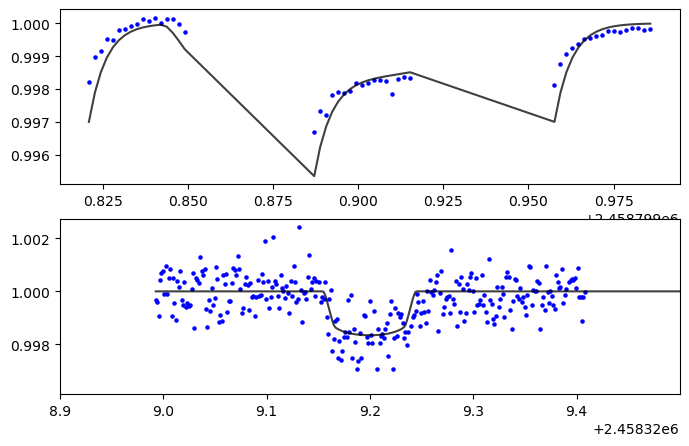

In [34]:
transit_model_HST = transit(theta_init, BATMAN_HSTinitmodel, 'hst')
transit_model_TESS = transit(theta_init, BATMAN_TESSinitmodel, 'tess')
hook_model = hook(theta_init)
ramp_model = ramp(theta_init)
modelHST = transit_model_HST * hook_model * ramp_model
modelTESS = transit_model_TESS

lnPost_init = lnPosterior(theta_init)
print('Initial lnPosterior:', lnPost_init)
fig, ax = plt.subplots(figsize=(8,5), nrows=2)
ax[0].plot(times_h, modelHST, c='black', alpha=0.75)
ax[0].scatter(times_h, fluxes_h, c='blue', s=5)

ax[1].plot(times_t, modelTESS, c='black', alpha=0.75)
ax[1].scatter(times_t, fluxes_t, c='blue', s=5)
ax[1].set_xlim((lit_tc-.3), (lit_tc+.3))
#ax[1].axvline(lit_tc, c='gray', alpha=0.75)
plt.show()

In [36]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions
Nsteps = 40000

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

try:
    %store -r bb_paramfits
    %store -r bb_paramerrs
    for i in range(Ndimensions):
        pos[:,i] = bb_paramfits[i] + 0.5*np.random.normal(0., bb_paramerrs[i], Nwalkers)
    print('Initialized with stored values')
except:
    try:
        # if we ran this before, initialize based on previous run's best fits
        for i in range(Ndimensions):
            pos[:,i] = param_fits[i] + 0.5*np.random.normal(0., param_uperrs[i], Nwalkers)
    except:
        # if not, then use theta_init array
        for i in range(Ndimensions):
            pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)

# for i in range(Ndimensions):
#             pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)


Initialized with stored values


In [37]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 40000/40000 [02:30<00:00, 266.19it/s]


In [39]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()

burn = 1000
samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

# Generating models with best-fit parameters
bf_HSTtransit = transit(param_fits, BATMAN_HSTinitmodel, 'hst')
bf_TESStransit = transit(param_fits, BATMAN_TESSinitmodel, 'tess')
bf_hook = hook(param_fits)
#bf_ramp = ramp(param_fits)
bf_HSTmodel = bf_HSTtransit * bf_hook #* bf_ramp
bf_HSTsyst = bf_hook * bf_ramp
bf_TESSmodel = bf_TESStransit

detflux_h, deterrs_h = fluxes_h / bf_HSTsyst, errors_h / bf_HSTsyst


# Generating a smooth transit light curve with best-fit parameters for plotting purposes
times_h_smooth = np.linspace(times_h[0], times_h[-1], 100)
times_t_smooth = np.linspace(times_t[0], times_t[-1], 5000)
BFParams = batman.TransitParams()
BFParams.t0 = param_fits[0]      
BFParams.per = 10.**param_fits[1]
BFParams.a = 10.**param_fits[2]
BFParams.inc = np.arccos(param_fits[3])*(180./np.pi)
BFParams.rp = param_fits[4]
BFParams.ecc = 0.
BFParams.w = 90.
BFParams.limb_dark = 'quadratic'
BFParams.u = [0.33, 0.2]
BATMAN_HSTsmoothmodel = batman.TransitModel(BFParams, times_h_smooth)
transit_h_smooth = transit(param_fits, BATMAN_HSTsmoothmodel, 'hst')
BFParams.rp = param_fits[11]
BATMAN_TESSsmoothmodel = batman.TransitModel(BFParams, times_t_smooth)
transit_t_smooth = transit(param_fits, BATMAN_TESSsmoothmodel, 'tess')

storeVals = True
if storeVals:
    bb_paramfits = np.copy(param_fits)
    bb_paramerrs = np.copy(param_uperrs)
    %store bb_paramfits
    %store bb_paramerrs

Stored 'bb_paramfits' (ndarray)
Stored 'bb_paramerrs' (ndarray)


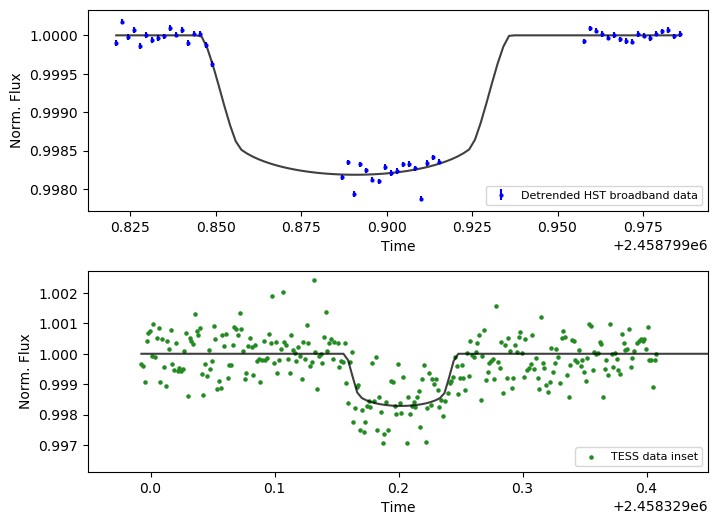

In [40]:
#lnPost_init = lnPosterior(theta_init)
#print('Initial lnPosterior:', lnPost_init)
fig, ax = plt.subplots(figsize=(8,6), nrows=2)
plt.subplots_adjust(hspace=0.3)
ax[0].plot(times_h_smooth, transit_h_smooth, c='black', alpha=0.75)
ax[0].errorbar(times_h, detflux_h, deterrs_h, marker='o', ls='None', c='blue', ms=2, label='Detrended HST broadband data')
ax[0].set(xlabel='Time', ylabel='Norm. Flux')
ax[0].legend(loc='lower right', frameon=True, fontsize=8)

ax[1].plot(times_t_smooth, transit_t_smooth, c='black', alpha=0.75)
ax[1].scatter(times_t, fluxes_t, c='forestgreen', s=5, label='TESS data inset')
ax[1].set_xlim((lit_tc-.25), (lit_tc+.25))
ax[1].set(xlabel='Time', ylabel='Norm. Flux')
ax[1].legend(loc='lower right', frameon=True, fontsize=8)
#ax[1].axvline(lit_tc, c='gray', alpha=0.75)
plt.show()

In [41]:
## things to print out
# best fit parameters
# derived parameters (period, transit depth, etc)
# errors (average uncertainties, residuals, etc)

In [49]:
headers = ["Fit Value", "Upper error", "Lower error"]
l = []
for i, val in enumerate(labels):
    new = [labels[i], param_fits[i], param_uperrs[i], param_loerrs[i]]
    l.append(new)
    
from tabulate import tabulate    
table = tabulate(l, headers, tablefmt='orgtbl')
print('Best-Fit Fitting Parameters')
print(table)

## Computing derived parameters
# transit depth [ppm]
tdepthHST_chain = (flatsamples[:,4]**2)*1.e6
tdepthHST_fit = np.median(tdepthHST_chain)
tdepthHST_uperr = np.percentile(tdepthHST_chain, 84) - tdepthHST_fit
tdepthHST_loerr = tdepthHST_fit - np.percentile(tdepthHST_chain, 16)

tdepthTESS_chain = (flatsamples[:,11]**2)*1.e6
tdepthTESS_fit = np.median(tdepthTESS_chain)
tdepthTESS_uperr = np.percentile(tdepthTESS_chain, 84) - tdepthTESS_fit
tdepthTESS_loerr = tdepthTESS_fit - np.percentile(tdepthTESS_chain, 16)
# period [day]
P_chain = 10.**(flatsamples[:,1])
P_fit = np.median(P_chain)
P_uperr = np.percentile(P_chain, 84) - P_fit
P_loerr = P_fit - np.percentile(P_chain, 16)

# inclination [deg]
inc_chain = np.arccos(flatsamples[:,3])*180./np.pi
inc_fit = np.median(inc_chain)
inc_uperr = np.percentile(inc_chain, 84) - inc_fit
inc_loerr = inc_fit - np.percentile(inc_chain, 16)

derived_labels = np.asarray(['HST depth', 'TESS depth', 'P [day]', 'i [deg]'])
dp_fits = np.asarray([tdepthHST_fit, tdepthTESS_fit, P_fit, inc_fit])
dp_uperrs = np.asarray([tdepthHST_uperr, tdepthTESS_uperr, P_uperr, inc_uperr])
dp_loerrs = np.asarray([tdepthHST_loerr, tdepthTESS_loerr, P_loerr, inc_loerr])
dl = []
for i, val in enumerate(derived_labels):
    dl.append([derived_labels[i], dp_fits[i], dp_uperrs[i], dp_loerrs[i]])
print('Derived Parameters')
table2 = tabulate(dl, headers, tablefmt='orgtbl')
print(table2)

## error statistics
print('Error Statistics')
residualsHST = fluxes_h - bf_HSTmodel
residualsTESS = fluxes_t - bf_TESSmodel
mean_residualHST = np.mean(abs(residualsHST))
mean_residualTESS = np.mean(abs(residualsTESS))
print('HST Mean Residual = %.2f ppm'%(mean_residualHST*1.e6))
print('TESS Mean Residual = %.2f ppm'%(mean_residualTESS*1.e6))
mean_dataerrHST = np.mean(errors_h)
mean_dataerrTESS = np.mean(errors_t)
print('HST Mean Data Error = %.2f ppm'%(mean_dataerrHST*1.e6))
print('TESS Mean Data Error = %.2f ppm'%(mean_dataerrTESS*1.e6))
mean_deterrHST = np.mean(deterrs_h)
print('HST Mean Detrended Error = %.2f ppm'%(mean_deterrHST*1.e6))
bf_lnPost = lnPosterior(param_fits)
print('Best Fit lnPosterior = ', bf_lnPost)
print('Bayesian Statistics')
Ndata = len(times_h)+len(times_t)
print('N data points = %d'%(Ndata))
print('N parameters = %d'%(Ndimensions))
bf_BIC = computeBIC(Ndimensions, Ndata, bf_lnPost)
print('BIC = %.2f'%(bf_BIC))

Best-Fit Fitting Parameters
|           |    Fit Value |   Upper error |   Lower error |
|-----------+--------------+---------------+---------------|
| tc        |  2.45833e+06 |   0.000495491 |   0.000494062 |
| log10P    |  0.780639    |   5.77174e-07 |   5.70501e-07 |
| log10a    |  1.12564     |   0.00869671  |   0.00853456  |
| cosi      |  0.0623985   |   0.00176979  |   0.0017855   |
| RpRs_hst  |  0.0437519   |   0.00033524  |   0.000335579 |
| amp1      |  0.00189344  |   3.2682e-05  |   3.32157e-05 |
| amp2      |  0.00150679  |   3.31897e-05 |   3.29395e-05 |
| amp3      |  0.00167709  |   3.16778e-05 |   3.11379e-05 |
| tau1      |  0.00560405  |   0.000267079 |   0.000251511 |
| tau2      |  0.00494686  |   0.000249245 |   0.000238617 |
| tau3      |  0.00532261  |   0.000242008 |   0.000229435 |
| RpRs_tess |  0.0425347   |   0.000514925 |   0.000514322 |
| slope     | -0.00235749  |   0.000181814 |   0.000187766 |
| intcpt    |  1           |   1.37985e-05 |   1.32011e-0

In [48]:
## Printing out fit values that don't fully print in the table:
print('best fit t_c')
print(param_fits[0])
print('best fit P')
print(P_fit)

best fit t_c
2458329.201974941
best fit P
6.034471683850292


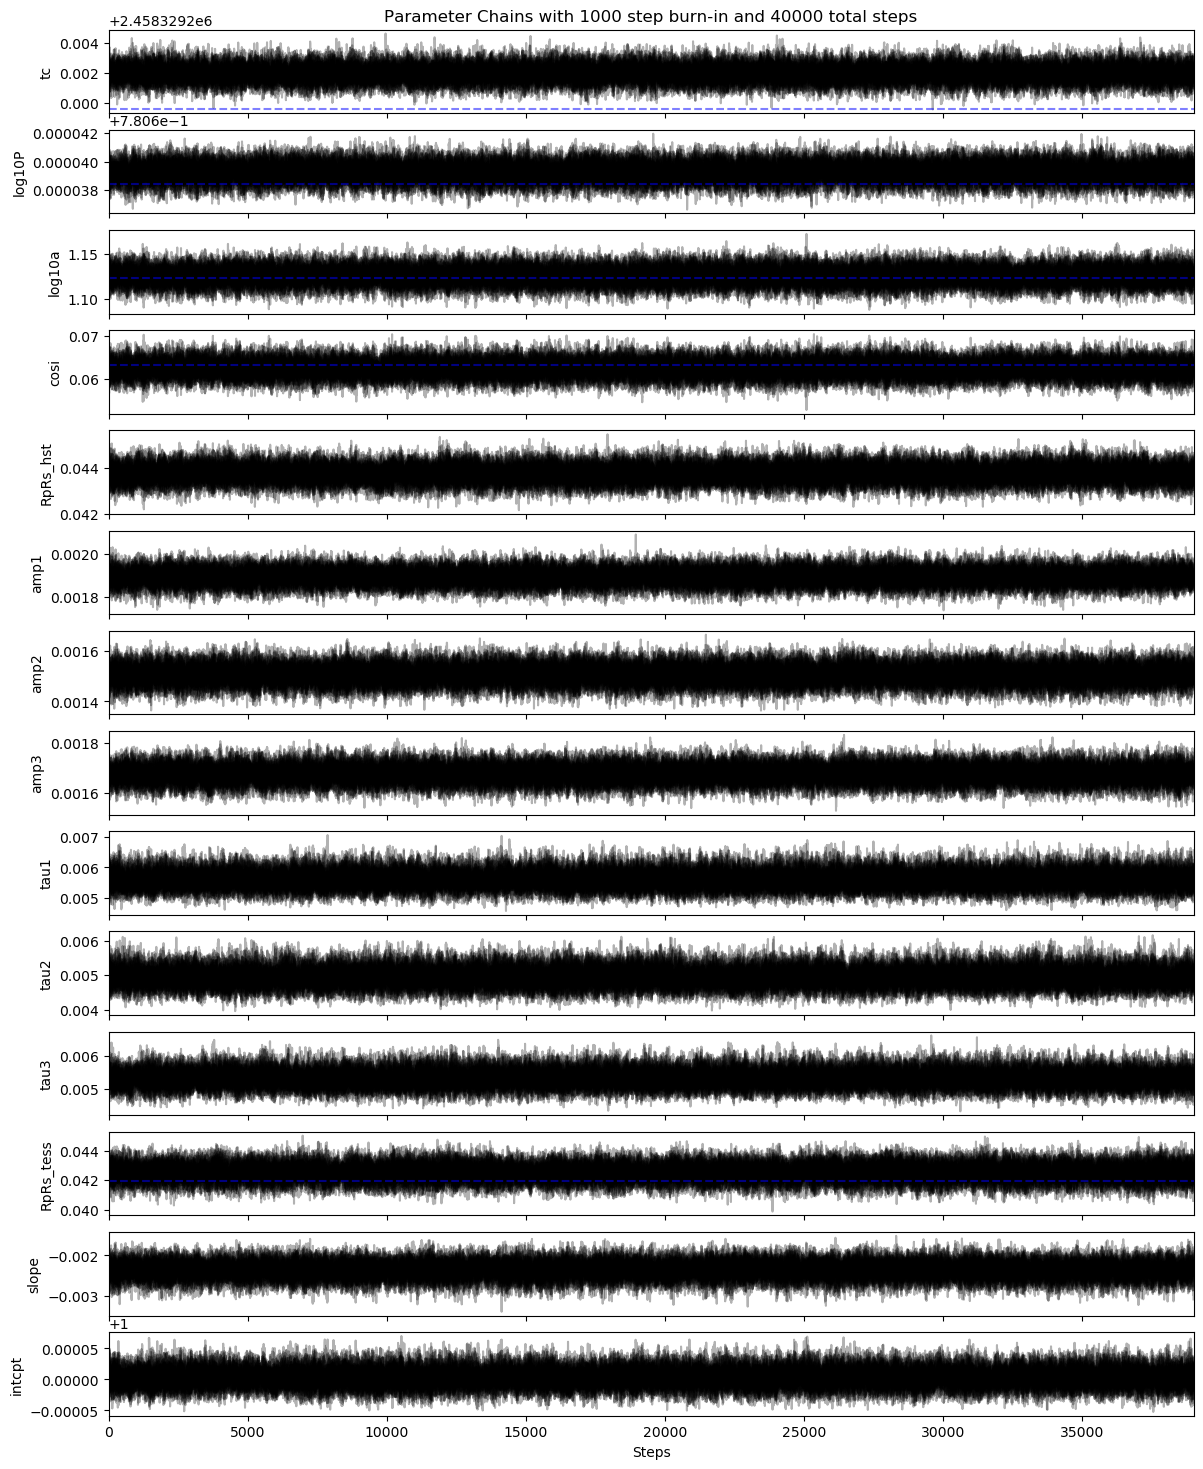

In [46]:
fig, axes = plt.subplots(samples.shape[2], figsize=(14,18), sharex=True)
for i in range(samples.shape[2]):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.axhline(priors[i], c='blue', ls='--', alpha=0.5)
    
axes[0].set_title('Parameter Chains with %d step burn-in and %d total steps'%(burn, Nsteps))
axes[-1].set_xlabel('Steps')
plt.savefig('figures/HSTbroadbandfit_chains.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# cornerfig = corner.corner(flatsamples, labels=labels, show_titles=True)
# plt.show()